In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from functools import partial
from itertools import product
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import re
import time
import datetime

from my_modules.plot_and_stat_funcs import *
from my_modules.transformations import *

In [2]:
data_folder = 'data/'

In [3]:
X_train = pd.read_csv(data_folder + 'X_train.csv')
y_train = pd.read_csv(data_folder + 'y_train.csv').target
X_val = pd.read_csv(data_folder + 'X_val.csv')
y_val = pd.read_csv(data_folder + 'y_val.csv').target
X_test = pd.read_csv(data_folder + 'X_test.csv')
test = pd.read_csv(data_folder + 'test.csv')
submission = pd.read_csv(data_folder + 'sample_submission.csv')

In [4]:
X_train.head(1)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,...,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",Encoded_Customers,Encoded_sum_target
0,1,6,0,0,0,893,127,29,5,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [5]:
test_store_ids = test.Store.unique()

In [6]:
is_train_in_test_mask = X_train.Store.isin(test_store_ids)
X_train = X_train[is_train_in_test_mask]
train_stores = X_train.Store
X_train.drop(columns='Store', inplace=True)
y_train = y_train[is_train_in_test_mask]

is_val_in_test_mask = X_val.Store.isin(test_store_ids)
X_val = X_val[is_val_in_test_mask]
val_stores = X_val.Store
X_val.drop(columns='Store', inplace=True)
y_val = y_val[is_val_in_test_mask]

test_stores = X_test.Store
X_test.drop(columns='Store', inplace=True)

As light GBM allows only alphanumeric characters and underscores in column names remove other characters.

In [7]:
X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)

In [8]:
X_train.head(1)

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,...,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,6,0,0,0,893,127,29,5,0,0.0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [9]:
def RMSPE(y_true, y_pred):
    y_t, y_p = np.array(y_true), np.array(y_pred)
    y_t, y_p = y_t[np.abs(y_t) > 1e-3], y_p[np.abs(y_t) > 1e-3]
    return np.sqrt(np.mean(
        ((y_t - y_p) / y_t)**2
    ))

In [10]:
def all_info_about_model(model_init, X_train, y_train, X_val, y_val, metric, param_grid, include_train=True, show_loop_params=True, *fit_args, **fit_kwargs):
    param_names = list(param_grid.keys())
    param_values = list(product(*list(param_grid.values())))
    scores_df = pd.DataFrame(param_values, columns=param_names)
    if include_train:
        train_scores = []
    val_scores = []
    eval_time = []
    for i, param_value in enumerate(param_values):
        start = time.time()
        params = dict(zip(param_names, param_value))
        if show_loop_params:
            print('\n', params, '\n')
        model = model_init(**params)
        model.fit(X_train, y_train, *fit_args, **fit_kwargs)
        if include_train:
            train_scores.append(metric(y_train, model.predict(X_train)))
        val_scores.append(metric(y_val, model.predict(X_val)))
        eval_time.append(time.time() - start)
    
    if include_train:
        scores_df.loc[:, 'train_metric'] = train_scores
    scores_df.loc[:, 'val_metric'] = val_scores
    scores_df.loc[:, 'eval_time (sec)'] = eval_time
    
    return scores_df

In [11]:
def plot_eval_results(x, data):
    plt.figure(figsize=(12, 7))
    plt.plot(data[x], data['train_metric'])
    plt.plot(data[x], data['val_metric'])
    plt.legend(['train_rmspe', 'val_rmspe'])
    plt.xlabel(x)
    plt.ylabel('rmspe')
    plt.title(f'rmspe on train and validation datasets depending on {x}')
    plt.xticks(ticks=data[x], labels=data[x])
    plt.show()

# LGBM

## Origin target

restart this and change params to tune

In [ ]:
max_depth_results = all_info_about_model(partial(LGBMRegressor, num_leaves=1000, n_estimators=1000, random_state=205,),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'max_depth': [-1] + list(range(1, 14)),
                     },
                     show_loop_params=True,
)


 {'max_depth': -1} 


 {'max_depth': 1} 


 {'max_depth': 2} 


 {'max_depth': 3} 


 {'max_depth': 4} 


 {'max_depth': 5} 


 {'max_depth': 6} 


 {'max_depth': 7} 


 {'max_depth': 8} 


 {'max_depth': 9} 


 {'max_depth': 10} 


 {'max_depth': 11} 


 {'max_depth': 12} 


 {'max_depth': 13} 



In [ ]:
#max_depth_results = pd.read_csv('data/results/max_depth_results.csv')

In [ ]:
max_depth_results

,max_depth,train_metric,val_metric,eval_time (sec)
0,-1,0.070303,0.150834,171.271270
1,1,0.244407,0.229102,32.508111
2,2,0.198337,0.173770,43.460228
3,3,0.168726,0.161353,51.636497
4,4,0.153225,0.154374,62.683120
5,5,0.137390,0.146276,75.435896
6,6,0.124461,0.144389,95.216098
7,7,0.113631,0.135009,116.854528
8,8,0.104895,0.134493,142.266122
9,9,0.096600,0.138471,167.767686


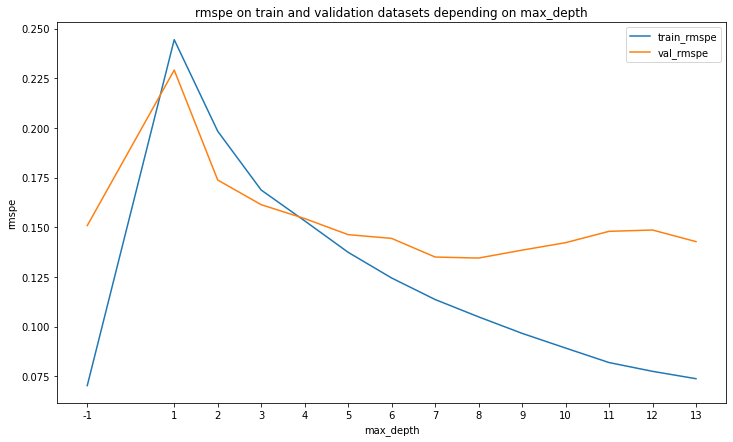

In [ ]:
plot_eval_results('max_depth', max_depth_results)

The least val rmspe is for max_depth in \[5, 6, 7\].

In [ ]:
num_leaves_results = all_info_about_model(partial(LGBMRegressor, n_estimators=1000, random_state=205,),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'num_leaves': list(range(10, 121, 10)),
                     },
                     show_loop_params=True,
)
num_leaves_results.to_csv(data_folder + 'results/num_leaves_results.csv', index=False)


 {'num_leaves': 10} 


 {'num_leaves': 20} 


 {'num_leaves': 30} 


 {'num_leaves': 40} 


 {'num_leaves': 50} 


 {'num_leaves': 60} 


 {'num_leaves': 70} 


 {'num_leaves': 80} 


 {'num_leaves': 90} 


 {'num_leaves': 100} 


 {'num_leaves': 110} 


 {'num_leaves': 120} 



In [ ]:
num_leaves_results = pd.read_csv(data_folder + 'results/num_leaves_results.csv')

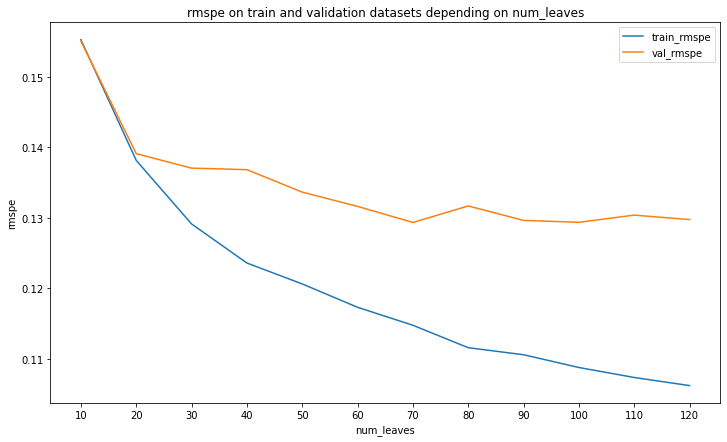

In [ ]:
plot_eval_results('num_leaves', num_leaves_results)

In [ ]:
max_depth_num_leaves_results = all_info_about_model(partial(LGBMRegressor, n_estimators=1000, random_state=205, ),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'max_depth': [-1, 6, 7, 8, 9],
                         'num_leaves': [60, 70, 80, 90],
                     },
                     show_loop_params=True,
)
max_depth_num_leaves_results.to_csv(data_folder + 'results/max_depth_num_leaves_results.csv', index=False)


 {'max_depth': -1, 'num_leaves': 60} 


 {'max_depth': -1, 'num_leaves': 70} 


 {'max_depth': -1, 'num_leaves': 80} 


 {'max_depth': -1, 'num_leaves': 90} 


 {'max_depth': 6, 'num_leaves': 60} 


 {'max_depth': 6, 'num_leaves': 70} 


 {'max_depth': 6, 'num_leaves': 80} 


 {'max_depth': 6, 'num_leaves': 90} 


 {'max_depth': 7, 'num_leaves': 60} 


 {'max_depth': 7, 'num_leaves': 70} 


 {'max_depth': 7, 'num_leaves': 80} 


 {'max_depth': 7, 'num_leaves': 90} 


 {'max_depth': 8, 'num_leaves': 60} 


 {'max_depth': 8, 'num_leaves': 70} 


 {'max_depth': 8, 'num_leaves': 80} 


 {'max_depth': 8, 'num_leaves': 90} 


 {'max_depth': 9, 'num_leaves': 60} 


 {'max_depth': 9, 'num_leaves': 70} 


 {'max_depth': 9, 'num_leaves': 80} 


 {'max_depth': 9, 'num_leaves': 90} 



In [ ]:
max_depth_num_leaves_results = pd.read_csv(data_folder + 'results/max_depth_num_leaves_results.csv')

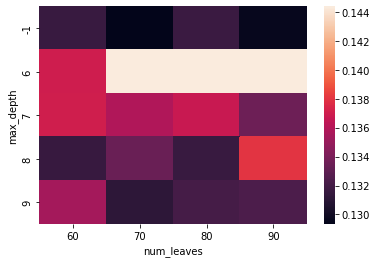

In [ ]:
sns.heatmap(max_depth_num_leaves_results.set_index(['max_depth', 'num_leaves']).unstack()['val_metric'])
plt.show()

In [ ]:
max_depth_num_leaves_results.loc[[max_depth_num_leaves_results.val_metric.argmin()]]

,max_depth,num_leaves,train_metric,val_metric,eval_time (sec)
1,-1,70,0.114745,0.129346,77.202977


So the parameters that minimize rmspe are max_depth=-1 and num_leaves=70

Let's see how the error depends on learning_rate parameter.

In [ ]:
learning_rate_results = all_info_about_model(partial(LGBMRegressor, max_depth=-1, num_leaves=70, n_estimators=5000, random_state=205, ),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'learning_rate': np.linspace(0.05, 0.15, 11),
                     },
                     eval_set=[(X_val, y_val)],
                     eval_metric=lambda y_true, y_pred: ('RMSPE', RMSPE(y_true, y_pred), False),
                     early_stopping_rounds=150,
                     verbose=100,
                     show_loop_params=True,
)
learning_rate_results.to_csv(data_folder + 'results/learning_rate_results.csv', index=False)


 {'learning_rate': 0.05} 

Training until validation scores don't improve for 150 rounds.
[100]	valid_0's l2: 1.4531e+06	valid_0's RMSPE: 0.185911
[200]	valid_0's l2: 1.35158e+06	valid_0's RMSPE: 0.158716
[300]	valid_0's l2: 1.30151e+06	valid_0's RMSPE: 0.153741
[400]	valid_0's l2: 1.27511e+06	valid_0's RMSPE: 0.150512
[500]	valid_0's l2: 1.25509e+06	valid_0's RMSPE: 0.14728
[600]	valid_0's l2: 1.22864e+06	valid_0's RMSPE: 0.143284
[700]	valid_0's l2: 1.2133e+06	valid_0's RMSPE: 0.141472
[800]	valid_0's l2: 1.20318e+06	valid_0's RMSPE: 0.140296
[900]	valid_0's l2: 1.18851e+06	valid_0's RMSPE: 0.138786
[1000]	valid_0's l2: 1.17512e+06	valid_0's RMSPE: 0.137876
[1100]	valid_0's l2: 1.16051e+06	valid_0's RMSPE: 0.136484
[1200]	valid_0's l2: 1.14595e+06	valid_0's RMSPE: 0.13557
[1300]	valid_0's l2: 1.13553e+06	valid_0's RMSPE: 0.134679
[1400]	valid_0's l2: 1.12603e+06	valid_0's RMSPE: 0.134057
[1500]	valid_0's l2: 1.11813e+06	valid_0's RMSPE: 0.133567
[1600]	valid_0's l2: 1.11133e+06	vali

In [ ]:
learning_rate_results = pd.read_csv(data_folder + 'results/learning_rate_results.csv')

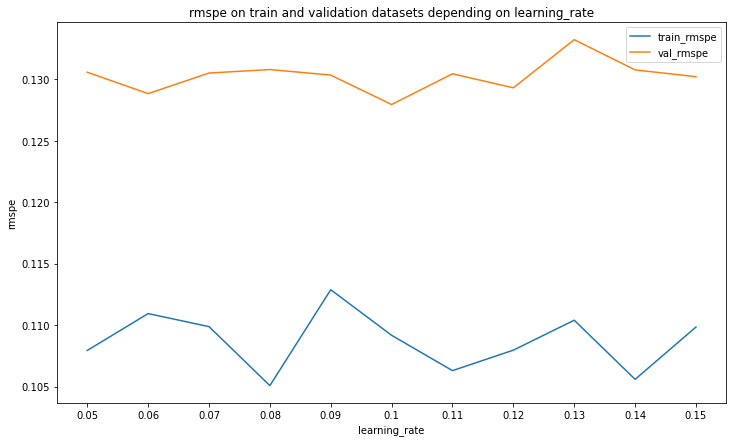

In [ ]:
plot_eval_results('learning_rate', learning_rate_results)

Let's see the row with minimum rmspe.

In [ ]:
learning_rate_results.loc[[learning_rate_results.val_metric.argmin()]]

,learning_rate,train_metric,val_metric,eval_time (sec)
5,0.1,0.109168,0.127942,120.04615


The best params are max_depth=-1, num_leaves=70, learning_rate=0.1

## Transformed target

Boks-Koks transforming  
$
z = \begin{cases}
\frac{(y+a)^\lambda - 1}{\lambda}, \lambda \ne 0\\
ln(y+a), \lambda=0
\end{cases}
$

In [12]:
def box_cox(y, mu, shift=0.0):
    if mu == 0.0:
        return np.log(y + shift)
    return ((y + shift)**mu - 1) / mu

def inv_box_cox(z, mu, shift=0.0):
    if mu == 0.0:
        return np.e**z - shift
    return (1 + z * mu)**(1 / mu) - shift

def box_cox_RMSPE(y_true, y_pred, mu, shift):
    return RMSPE(inv_box_cox(y_true, mu, shift), inv_box_cox(y_pred, mu, shift))

In [ ]:
boxcox_scores = []
mus = np.linspace(0, 1, 21)
for mu in mus:
    print('mu:', mu, '\n')
    shift = 1
    y_train_boxcox = box_cox(y_train, mu, shift)
    y_val_boxcox = box_cox(y_val, mu, shift)
    
    lgbm_boxcox = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.1, n_estimators=5000, random_state=205)
    lgbm_boxcox.fit(X_train, y_train_boxcox,
                                        eval_set=[(X_val, y_val_boxcox)],
                            eval_metric=lambda y_true, y_pred: ('RMSPE', box_cox_RMSPE(y_true, y_pred, mu, shift), False),
                                        early_stopping_rounds=150,
                                        verbose=100,
    )
    boxcox_scores.append(box_cox_RMSPE(y_val_boxcox, lgbm_boxcox.predict(X_val), mu, shift))

mu: 0.0 

Training until validation scores don't improve for 150 rounds.
[100]	valid_0's l2: 0.0251007	valid_0's RMSPE: 0.15252
[200]	valid_0's l2: 0.0255061	valid_0's RMSPE: 0.149695
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0240561	valid_0's RMSPE: 0.156888
mu: 0.05 

Training until validation scores don't improve for 150 rounds.
[100]	valid_0's l2: 0.0575571	valid_0's RMSPE: 0.153526
[200]	valid_0's l2: 0.0543062	valid_0's RMSPE: 0.14564
[300]	valid_0's l2: 0.0514677	valid_0's RMSPE: 0.141063
[400]	valid_0's l2: 0.0496448	valid_0's RMSPE: 0.138113
[500]	valid_0's l2: 0.0485896	valid_0's RMSPE: 0.136018
[600]	valid_0's l2: 0.0471853	valid_0's RMSPE: 0.134128
[700]	valid_0's l2: 0.0462244	valid_0's RMSPE: 0.132894
[800]	valid_0's l2: 0.045404	valid_0's RMSPE: 0.131859
[900]	valid_0's l2: 0.0448186	valid_0's RMSPE: 0.131045
[1000]	valid_0's l2: 0.0444147	valid_0's RMSPE: 0.130554
[1100]	valid_0's l2: 0.0441291	valid_0's RMSPE: 0.130191
[1200]	valid_0's l2: 0.0438794	valid

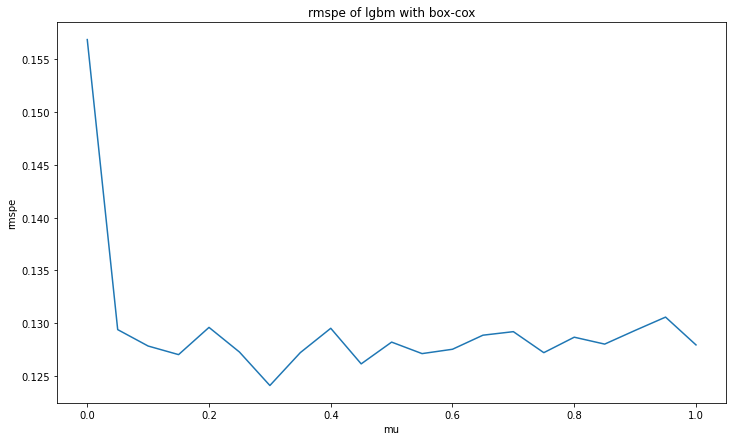

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(mus, boxcox_scores)
plt.xlabel('mu')
plt.ylabel('rmspe')
plt.title('rmspe of lgbm with box-cox')
plt.show()

In [ ]:
print('The minimum rmspe:', min(boxcox_scores))
print('The mu parameter:', mus[np.argmin(boxcox_scores)])

The minimum rmspe: 0.12409362139537163
The mu parameter: 0.30000000000000004


The rmspe for origin target is 0.127942. So the transformation is useful

In [ ]:
mu = 0.3
shift = 1
y_train_boxcox = box_cox(y_train, mu, shift)
y_val_boxcox = box_cox(y_val, mu, shift)

# Linear Regression

In [ ]:
X_train.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,6,0,0,0,893,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,5,0,0,0,892,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,4,0,0,0,891,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,3,0,0,0,890,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,2,0,0,0,889,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [ ]:
cols_to_normalize = ['DayOfWeek', 'ordered_day', 'ordered_week', 'ordered_month']
scaler = MinMaxScaler()

X_train_norm = X_train.copy()
X_train_norm.loc[:, cols_to_normalize] = scaler.fit_transform(X_train_norm[cols_to_normalize])

X_val_norm = X_val.copy()
X_val_norm.loc[:, cols_to_normalize] = scaler.transform(X_val_norm[cols_to_normalize])

In [ ]:
X_train_norm.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,0.833333,0,0,0,1.000000,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,0.666667,0,0,0,0.998880,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,0.500000,0,0,0,0.997760,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,0.333333,0,0,0,0.996641,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,0.166667,0,0,0,0.995521,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [ ]:
X_train_norm_nonzero = X_train_norm[y_train != 0]
y_train_norm_nonzero = y_train[y_train != 0]

X_val_norm_nonzero = X_val_norm[y_val != 0]
y_val_norm_nonzero = y_val[y_val != 0]

In [ ]:
lin_reg = ElasticNet()
lin_reg.fit(X_train_norm_nonzero, y_train_norm_nonzero, sample_weight=1/y_train_norm_nonzero**2)
lin_reg_predicted = lin_reg.predict(X_val_norm_nonzero)

In [ ]:
RMSPE(y_val_norm_nonzero, lin_reg_predicted)

0.2668527236908827

# kNN

In [22]:
knn_scores = []
knn_n_neighbors = range(2, 17, 2)
for n_neighbors in knn_n_neighbors:
    print('n_neighbors:', n_neighbors, '\n')
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train_norm, y_train)
    knn_predicted = knn.predict(X_val_norm)
    knn_scores.append(RMSPE(y_val, knn_predicted))

n_neighbors: 2 

n_neighbors: 4 

n_neighbors: 6 

n_neighbors: 8 

n_neighbors: 10 

n_neighbors: 12 

n_neighbors: 14 

n_neighbors: 16 



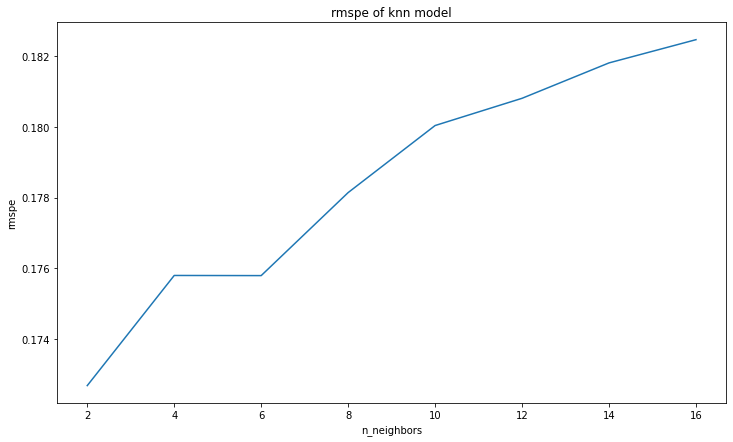

In [23]:
plt.figure(figsize=(12, 7))
plt.plot(knn_n_neighbors, knn_scores)
plt.xlabel('n_neighbors')
plt.ylabel('rmspe')
plt.title('rmspe of knn model')
plt.xticks(ticks=knn_n_neighbors, labels=knn_n_neighbors)
plt.show()

# Submitting

In [20]:
X = pd.concat([X_train, X_val], ignore_index=True)
y = pd.concat([y_train, y_val], ignore_index=True)

In [21]:
mu_best = 0.3

The number of estimators equals 1447 because it was the best iteration for the best model when tuning the box-cox parameters.

In [22]:
lgbm_final = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.1, n_estimators=1447, random_state=205)
lgbm_final.fit(X, box_cox(y, mu=mu_best, shift=1.0),)

LGBMRegressor(n_estimators=1447, num_leaves=70, random_state=205)

In [23]:
train_prediction = inv_box_cox(lgbm_final.predict(X_train), mu=mu_best, shift=1.0)
val_prediction = inv_box_cox(lgbm_final.predict(X_val), mu=mu_best, shift=1.0)
test_prediction = inv_box_cox(lgbm_final.predict(X_test), mu=mu_best, shift=1.0)

In [24]:
RMSPE(y_train, train_prediction)

0.10086177760789446

In [25]:
RMSPE(y_val, val_prediction)

0.0782054307208756

saving the submission

In [18]:
train_predict_df = X_train.copy()
train_predict_df.loc[:, 'Store'] = train_stores
train_predict_df.loc[:, 'target'] = y_train

val_predict_df = X_val.copy()
val_predict_df.loc[:, 'Store'] = val_stores
val_predict_df.loc[:, 'target'] = y_val

test_predict_df = X_test.copy()
test_predict_df.loc[:, 'Store'] = test_stores

In [26]:
test['ordered_day'] = test.Date.apply(lambda date: (datetime.datetime.strptime(date, '%Y-%m-%d') - datetime.datetime(2013, 1, 1)).days)

In [27]:
test_predict_df['prediction'] = test_prediction
test_predict_df['Store'] = test_stores

In [28]:
prediction = test[['Id', 'Store', 'ordered_day']].merge(test_predict_df[['Store', 'ordered_day', 'prediction']])[['Id', 'prediction']]

In [29]:
submission = pd.read_csv(data_folder + 'sample_submission.csv')
submission = submission[['Id']].merge(prediction, on='Id', how='left').fillna(0).rename(columns={'prediction': 'Sales'})
submission.to_csv(data_folder + 'submission_lgbm.csv', index=False)

rmspe = 0.16765

In [30]:
train_predict_df.loc[:, 'full_prediction'] = train_prediction
val_predict_df.loc[:, 'full_prediction'] = val_prediction
test_predict_df.loc[:, 'full_prediction'] = test_prediction

In [14]:
lgbm_best = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.1, n_estimators=1447, random_state=205)
lgbm_best.fit(X_train, box_cox(y_train, mu=mu_best, shift=1.0),)

LGBMRegressor(n_estimators=1447, num_leaves=70, random_state=205)

In [16]:
train_prediction = inv_box_cox(lgbm_best.predict(X_train), mu=mu_best, shift=1.0)
val_prediction = inv_box_cox(lgbm_best.predict(X_val), mu=mu_best, shift=1.0)
test_prediction = inv_box_cox(lgbm_best.predict(X_test), mu=mu_best, shift=1.0)

In [19]:
train_predict_df.loc[:, 'part_prediction'] = train_prediction
val_predict_df.loc[:, 'part_prediction'] = val_prediction
test_predict_df.loc[:, 'part_prediction'] = test_prediction

In [31]:
train_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'target', 'full_prediction', 'part_prediction']]\
                                                                                    .to_csv(data_folder + 'train_prediction.csv', index=False)
val_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'target', 'full_prediction', 'part_prediction']]\
                                                                                    .to_csv(data_folder + 'val_prediction.csv', index=False)
test_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'full_prediction', 'part_prediction']]\
                                                                                    .to_csv(data_folder + 'test_prediction.csv', index=False)